In [129]:
from comet_ml import API
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import numpy as np
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

In [130]:
def test_set_data(path):
    data = pd.read_csv(path)
    return data

In [131]:
def download_model(username, project_name, experiment_key, model_name,ver):
    api = API()
    api.get(username+"/"+project_name+"/"+experiment_key)
    api.download_registry_model(username,model_name,version=ver, output_path="./models")

In [132]:
def preprocess_data(df):
    # Convert rebound to 0 and 1 instead of True and False
    df['rebound'] = df['rebound'].astype(int)
    # Rearranging columns to make it easier to process data
    df=df[['game_id','period','period_time','coordinates_x','coordinates_y','shot_distance','shot_angle','secondary_type','last_event_type','time_from_last_event(s)','distance_from_last_event','rebound','angle_change','speed','last_event_coordinates_x','last_event_coordinates_y','goal']]
    # Convert period_time to seconds
    df['period_time'] = df['period_time'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    # Convert secondary_type and last_event_type to dummy variables
    df = pd.get_dummies(df, columns=['secondary_type','last_event_type'], drop_first=True)
    return df

In [133]:
# Function to plot all the roc curves in a single plot of logistic regression(distance, angle , distance and angle) and xgboost models
def plot_roc_curve(lr_1_regular_f1_fpr, lr_1_regular_f1_tpr, lr_2_regular_f1_fpr, lr_2_regular_f1_tpr, lr_3_regular_f1_fpr, lr_3_regular_f1_tpr, xgb_regular_f2_fpr, xgb_regular_f2_tpr,Random_forest_regular_f2_fpr,Random_forest_regular_f2_tpr):
    pyplot.plot(lr_1_regular_f1_fpr, lr_1_regular_f1_tpr, marker='.', label='Logistic Regression distance model')
    pyplot.plot(lr_2_regular_f1_fpr, lr_2_regular_f1_tpr, marker='.', label='Logistic Regression angle model')
    pyplot.plot(lr_3_regular_f1_fpr, lr_3_regular_f1_tpr, marker='.', label='Logistic Regression distance and angle model')
    pyplot.plot(xgb_regular_f2_fpr, xgb_regular_f2_tpr, marker='.', label='XGBoost model')
    pyplot.plot(Random_forest_regular_f2_fpr, Random_forest_regular_f2_tpr, marker='.', label='Random Forest model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ROC-AUC Curve")
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [134]:
# Plot Goal rate vs probability percentile for logistic regression models(distance, angle , distance and angle) and xgboost models
def plot_goal_rate_vs_probability_percentile(y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs,random_forest_regular_f2_probs):
    lr_1_regular_f1_probs_percentile = np.percentile(lr_1_regular_f1_probs, np.arange(0, 100, 1))
    lr_2_regular_f1_probs_percentile = np.percentile(lr_2_regular_f1_probs, np.arange(0, 100, 1))
    lr_3_regular_f1_probs_percentile = np.percentile(lr_3_regular_f1_probs, np.arange(0, 100, 1))
    xgb_regular_f2_probs_percentile = np.percentile(xgb_regular_f2_probs, np.arange(0, 100, 1))
    random_forest_regular_f2_probs_percentile = np.percentile(random_forest_regular_f2_probs, np.arange(0, 100, 1))

    # Calculate the goal rate for each probability percentile
    lr_1_regular_f1_goal_rate = []
    lr_2_regular_f1_goal_rate = []
    lr_3_regular_f1_goal_rate = []
    xgb_regular_f2_goal_rate = []
    random_forest_f2_goal_rate = []

    for i in range(0, 100):
        lr_1_regular_f1_goal_rate.append(np.mean(y_regular_f1[lr_1_regular_f1_probs > lr_1_regular_f1_probs_percentile[i]]))
        lr_2_regular_f1_goal_rate.append(np.mean(y_regular_f1[lr_2_regular_f1_probs > lr_2_regular_f1_probs_percentile[i]]))
        lr_3_regular_f1_goal_rate.append(np.mean(y_regular_f1[lr_3_regular_f1_probs > lr_3_regular_f1_probs_percentile[i]]))
        xgb_regular_f2_goal_rate.append(np.mean(y_regular_f2[xgb_regular_f2_probs > xgb_regular_f2_probs_percentile[i]]))
        random_forest_f2_goal_rate.append(np.mean(y_regular_f2[random_forest_regular_f2_probs>random_forest_regular_f2_probs_percentile[i]]))


    pyplot.plot(np.arange(0, 100, 1), lr_1_regular_f1_goal_rate, marker='.', label='Logistic Regression distance model')
    pyplot.plot(np.arange(0, 100, 1), lr_2_regular_f1_goal_rate, marker='.', label='Logistic Regression angle model')
    pyplot.plot(np.arange(0, 100, 1), lr_3_regular_f1_goal_rate, marker='.', label='Logistic Regression distance and angle model')
    pyplot.plot(np.arange(0, 100, 1), xgb_regular_f2_goal_rate, marker='.', label='XGBoost model')
    pyplot.plot(np.arange(0, 100, 1), random_forest_f2_goal_rate, marker='.', label='Random Forest model')

    # Title
    pyplot.title("Plot Goal vs Probability Percentile")
    # axis labels
    pyplot.xlabel('Probability percentile')
    pyplot.ylabel('Goal rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [135]:
# Plot cumulative proportion of goals vs probability percentile for logistic regression(distance, angle , distance and angle) and xgboost models
def plot_cumulative_proportion_of_goals_vs_probability_percentile(y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs,random_forest_regular_f2_probs):
    lr_1_regular_f1_probs_percentile = np.percentile(lr_1_regular_f1_probs, np.arange(0, 100, 1))
    lr_2_regular_f1_probs_percentile = np.percentile(lr_2_regular_f1_probs, np.arange(0, 100, 1))
    lr_3_regular_f1_probs_percentile = np.percentile(lr_3_regular_f1_probs, np.arange(0, 100, 1))
    xgb_regular_f2_probs_percentile = np.percentile(xgb_regular_f2_probs, np.arange(0, 100, 1))
    random_forest_regular_f2_probs_percentile = np.percentile(random_forest_regular_f2_probs, np.arange(0, 100, 1))

    # Calculate the cumulative proportion of goals for each probability percentile
    lr_1_regular_f1_cumulative_proportion_of_goals = []
    lr_2_regular_f1_cumulative_proportion_of_goals = []
    lr_3_regular_f1_cumulative_proportion_of_goals = []
    xgb_regular_f2_cumulative_proportion_of_goals = []
    random_forest_f2_cumulative_proportion_of_goals = []

    for i in range(0, 100):
        lr_1_regular_f1_cumulative_proportion_of_goals.append(np.sum(y_regular_f1[lr_1_regular_f1_probs > lr_1_regular_f1_probs_percentile[i]])/np.sum(y_regular_f1))
        lr_2_regular_f1_cumulative_proportion_of_goals.append(np.sum(y_regular_f1[lr_2_regular_f1_probs > lr_2_regular_f1_probs_percentile[i]])/np.sum(y_regular_f1))
        lr_3_regular_f1_cumulative_proportion_of_goals.append(np.sum(y_regular_f1[lr_3_regular_f1_probs > lr_3_regular_f1_probs_percentile[i]])/np.sum(y_regular_f1))
        xgb_regular_f2_cumulative_proportion_of_goals.append(np.sum(y_regular_f2[xgb_regular_f2_probs > xgb_regular_f2_probs_percentile[i]])/np.sum(y_regular_f2))
        random_forest_f2_cumulative_proportion_of_goals.append(np.sum(y_regular_f2[random_forest_regular_f2_probs>random_forest_regular_f2_probs_percentile[i]])/np.sum(y_regular_f2))


    pyplot.plot(np.arange(0, 100, 1), lr_1_regular_f1_cumulative_proportion_of_goals, marker='.', label='Logistic Regression distance model')
    pyplot.plot(np.arange(0, 100, 1), lr_2_regular_f1_cumulative_proportion_of_goals, marker='.', label='Logistic Regression angle model')
    pyplot.plot(np.arange(0, 100, 1), lr_3_regular_f1_cumulative_proportion_of_goals, marker='.', label='Logistic Regression distance and angle model')
    pyplot.plot(np.arange(0, 100, 1), xgb_regular_f2_cumulative_proportion_of_goals, marker='.', label='XGBoost model')
    pyplot.plot(np.arange(0, 100, 1), random_forest_f2_cumulative_proportion_of_goals, marker='.', label='Random Forest model')

    # Title
    pyplot.title("Plot Cumulative Proportion of Goals vs Probability Percentile")
    # axis labels
    pyplot.xlabel('Probability percentile')
    pyplot.ylabel('Cumulative proportion of goals')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [136]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

In [171]:
def plot_calibration_curve(df_regular_f1,df_regular_f2,y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs, Random_forest_regular_f2_probs):
    # Calculate y_prob for each model for CalibrationDisplay
    lr_1_regular_f1_y_prob = []
    lr_2_regular_f1_y_prob = []
    lr_3_regular_f1_y_prob = []
    xgb_regular_f2_y_prob = []
    Random_forest_f2_y_prob = []
    for i in range(0, 100):
        lr_1_regular_f1_y_prob.append(np.mean(df_regular_f1['goal'][lr_1_regular_f1_probs > np.percentile(lr_1_regular_f1_probs, i)]))
        lr_2_regular_f1_y_prob.append(np.mean(df_regular_f1['goal'][lr_2_regular_f1_probs > np.percentile(lr_2_regular_f1_probs, i)]))
        lr_3_regular_f1_y_prob.append(np.mean(df_regular_f1['goal'][lr_3_regular_f1_probs > np.percentile(lr_3_regular_f1_probs, i)]))
        xgb_regular_f2_y_prob.append(np.mean(df_regular_f2['goal'][xgb_regular_f2_probs > np.percentile(xgb_regular_f2_probs, i)]))
        Random_forest_f2_y_prob.append(np.mean(df_regular_f2['goal'][Random_forest_regular_f2_probs > np.percentile(Random_forest_regular_f2_probs, i)]))
    lr_1_regular_f1_prob_true, lr_1_regular_f1_prob_pred = calibration_curve(y_regular_f1, lr_1_regular_f1_probs, n_bins=10)
    lr_2_regular_f1_prob_true, lr_2_regular_f1_prob_pred = calibration_curve(y_regular_f1, lr_2_regular_f1_probs, n_bins=10)
    lr_3_regular_f1_prob_true, lr_3_regular_f1_prob_pred = calibration_curve(y_regular_f1, lr_3_regular_f1_probs, n_bins=10)
    xgb_regular_f2_prob_true, xgb_regular_f2_prob_pred = calibration_curve(y_regular_f2, xgb_regular_f2_probs, n_bins=10)
    Random_forest_regular_f2_prob_true, Random_forest_regular_f2_prob_pred = calibration_curve(y_regular_f2, Random_forest_regular_f2_probs, n_bins=10)
    lr_1_regular_f1_display = CalibrationDisplay(lr_1_regular_f1_prob_true, lr_1_regular_f1_prob_pred, lr_1_regular_f1_y_prob)
    lr_2_regular_f1_display = CalibrationDisplay(lr_2_regular_f1_prob_true, lr_2_regular_f1_prob_pred, lr_2_regular_f1_y_prob)
    lr_3_regular_f1_display = CalibrationDisplay(lr_3_regular_f1_prob_true, lr_3_regular_f1_prob_pred, lr_3_regular_f1_y_prob)
    xgb_regular_f2_display = CalibrationDisplay(xgb_regular_f2_prob_true, xgb_regular_f2_prob_pred, xgb_regular_f2_y_prob)
    Random_forest_regular_f2_display = CalibrationDisplay(Random_forest_regular_f2_prob_true, Random_forest_regular_f2_prob_pred, Random_forest_regular_f2_probs)
    pyplot.show()
    lr_1_regular_f1_display.plot(ax=pyplot.gca(), name='Logistic Regression distance model')
    lr_2_regular_f1_display.plot(ax=pyplot.gca(), name='Logistic Regression angle model')
    lr_3_regular_f1_display.plot(ax=pyplot.gca(), name='Logistic Regression distance and angle model')
    xgb_regular_f2_display.plot(ax=pyplot.gca(), name='XGBoost model')
    Random_forest_regular_f2_display.plot(ax=pyplot.gca(), name= 'Random Forest model')
    # Display the legends on top left of the plot
    pyplot.legend(loc='upper left')
    pyplot.title("Calibration Curve")
    pyplot.show()

In [172]:
def preprocess_data_random(data):
    # Drop period_time 
    data = data.drop(['period_time'], axis=1)
    # Use one hot encoding to convert the categorical variables to numerical
    data = pd.get_dummies(data, columns=['secondary_type','last_event_type'], drop_first=True)
    return data


In [173]:
# Regular data from feature enigneering 1
df_regular_f1 = test_set_data("D:/NHLPro/data/test_data_regular.csv")
df_playoff_f1 = test_set_data("D:/NHLPro/data/test_data_playoff.csv")
    
# Regular and playoff test set data from feature engineering 2
df_regular_f2 = test_set_data("D:/NHLPro/data/M2_added_features_all_test_regular.csv")
df_playoff_f2 = test_set_data("D:/NHLPro/data/M2_added_features_all_test_playoff.csv")


In [174]:
# Download Logistic Regression distance model
download_model("rachel98", "ift-6758-team-8", "BnMYvXDZv9WBMuRmR8Zm5v3W7", "logisticregression1",'1.0.1')

# Load Logistic Regression distance model
lr_1_model = joblib.load("models/lr_dist.joblib")

#Download Logistic Regression Model 2
download_model("rachel98", "ift-6758-team-8", "dhhXTe3W1hWhWsixMvPMFwDTb", "logisticregression2",'1.0.1')

# Load Logistic Regression Model 2
lr_2_model = joblib.load("models/lr_angle.joblib")

# Download Logistic Regression Model 3
download_model("rachel98", "ift-6758-team-8", "teU07th2Uy3oouUfkX6u3BUv2", "logisticregression3",'1.0.1')

# Load Logistic Regression Model 3
lr_3_model = joblib.load("models/lr_dist_angle.joblib")

# Download XGBoost Final Model
download_model("rachel98", "ift-6758-team-8", "DPA8v9aBQumK4h2GAkMp6RA5d", "xgb3",'1.0.2')

# Load XGBoost Final Model
xgb_model = joblib.load("models/xgb3.joblib")

# Download random forest model
download_model("rachel98", "ift-6758-team-8", "nyTtBvXUJWq7j2TBdVGOh2bN0", "randomforesttuned-final","1.0.0")

# Load Random Forest Model
Random_forest_model = joblib.load("models/model2.joblib")


COMET INFO: Downloading registry model 'logisticregression1', version '1.0.1', stage None from workspace 'rachel98'...
COMET INFO: Unzipping model to 'c:\\Users\\pupne\\OneDrive\\Documents\\GitHub\\Team_IFT6758\\Team_8_IFT_6758\\src\\models\\models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logisticregression2', version '1.0.1', stage None from workspace 'rachel98'...
COMET INFO: Unzipping model to 'c:\\Users\\pupne\\OneDrive\\Documents\\GitHub\\Team_IFT6758\\Team_8_IFT_6758\\src\\models\\models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logisticregression3', version '1.0.1', stage None from workspace 'rachel98'...
COMET INFO: Unzipping model to 'c:\\Users\\pupne\\OneDrive\\Documents\\GitHub\\Team_IFT6758\\Team_8_IFT_6758\\src\\models\\models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'xgb3', version '1.0.2', stage None from workspace 'rachel98'...
COMET INFO: Unzipping model to 'c:\\Users\\pupne\\OneDrive\\Documents\\GitHub\\T

In [175]:
# Load Logistic Regression distance model
lr_1_model = joblib.load("models/lr_dist.joblib")

# Divide data into X and y
X_regular_f1 = df_regular_f1[['shot_distance']]
y_regular_f1 = df_regular_f1['goal']

# Predict on regular and playoff test set data from feature engineering 1
lr_1_regular_f1 = lr_1_model.predict(X_regular_f1)

# Predict accuracy on regular and playoff test set data from feature engineering 1
# Regular
lr_1_regular_f1_accuracy = accuracy_score(y_regular_f1, lr_1_regular_f1)
print("Logistic Regression distance model accuracy on regular test set data from feature engineering 1: ", lr_1_regular_f1_accuracy)    
    
# ROC curve for regular data
# calculate scores
lr_1_regular_f1_probs = lr_1_model.predict_proba(X_regular_f1)
# keep probabilities for the positive outcome only
lr_1_regular_f1_probs = lr_1_regular_f1_probs[:, 1]
# calculate roc curves
lr_1_regular_f1_fpr, lr_1_regular_f1_tpr, _ = roc_curve(y_regular_f1, lr_1_regular_f1_probs)
# calculate AUC
lr_1_regular_f1_auc = roc_auc_score(y_regular_f1, lr_1_regular_f1_probs)

Logistic Regression distance model accuracy on regular test set data from feature engineering 1:  0.9030358089181618


In [176]:
# Divide data into X and y
X_regular_f1 = df_regular_f1[['shot_angle']]
y_regular_f1 = df_regular_f1['goal']

# Predict on regular and playoff test set data from feature engineering 1
lr_2_regular_f1 = lr_2_model.predict(X_regular_f1)

# Predict accuracy on regular and playoff test set data from feature engineering 1
# Accuracy
lr_2_regular_f1_accuracy = accuracy_score(y_regular_f1, lr_2_regular_f1)
print("Logistic Regression angle model accuracy on regular test set data from feature engineering 1: ", lr_2_regular_f1_accuracy)
    
# calculate scores
lr_2_regular_f1_probs = lr_2_model.predict_proba(X_regular_f1)
# keep probabilities for the positive outcome only
lr_2_regular_f1_probs = lr_2_regular_f1_probs[:, 1]
# calculate roc curves
lr_2_regular_f1_fpr, lr_2_regular_f1_tpr, _ = roc_curve(y_regular_f1, lr_2_regular_f1_probs)
# calculate AUC
lr_2_regular_f1_auc = roc_auc_score(y_regular_f1, lr_2_regular_f1_probs)


Logistic Regression angle model accuracy on regular test set data from feature engineering 1:  0.9030358089181618


In [177]:
    # Divide data into X and y
    X_regular_f1 = df_regular_f1[['shot_distance', 'shot_angle']]
    y_regular_f1 = df_regular_f1['goal']

    # Predict on regular and playoff test set data from feature engineering 1
    lr_3_regular_f1 = lr_3_model.predict(X_regular_f1)
    
    # Predict accuracy on regular and playoff test set data from feature engineering 1
    # Accuracy
    lr_3_regular_f1_accuracy = accuracy_score(y_regular_f1, lr_3_regular_f1)
    print("Logistic Regression distance and angle model accuracy on regular test set data from feature engineering 1: ", lr_3_regular_f1_accuracy)

    # ROC curve for regular data
    # calculate scores
    lr_3_regular_f1_probs = lr_3_model.predict_proba(X_regular_f1)
    # keep probabilities for the positive outcome only
    lr_3_regular_f1_probs = lr_3_regular_f1_probs[:, 1]
    # calculate roc curves
    lr_3_regular_f1_fpr, lr_3_regular_f1_tpr, _ = roc_curve(y_regular_f1, lr_3_regular_f1_probs)
    # calculate AUC
    lr_3_regular_f1_auc = roc_auc_score(y_regular_f1, lr_3_regular_f1_probs)

Logistic Regression distance and angle model accuracy on regular test set data from feature engineering 1:  0.9030358089181618


In [178]:
    df_regular_f2 = preprocess_data(df_regular_f2)

    # Divide data into X and y
    # Divide data into X and y
    X_regular_f2 = df_regular_f2[['shot_angle','speed','shot_distance','distance_from_last_event','period_time','coordinates_y','time_from_last_event(s)']]
    y_regular_f2 = df_regular_f2['goal']

    # Predict on regular and playoff test set data from feature engineering 2
    xgb_regular_f2 = xgb_model.predict(X_regular_f2)

    # Predict accuracy on regular and playoff test set data from feature engineering 2
    # Accuracy
    xgb_regular_f2_accuracy = accuracy_score(y_regular_f2, xgb_regular_f2)
    print("XGBoost model accuracy on regular test set data from feature engineering 2: ", xgb_regular_f2_accuracy)
    
    # calculate scores
    xgb_regular_f2_probs = xgb_model.predict_proba(X_regular_f2)
    # keep probabilities for the positive outcome only
    xgb_regular_f2_probs = xgb_regular_f2_probs[:, 1]
    # calculate roc curves
    xgb_regular_f2_fpr, xgb_regular_f2_tpr, _ = roc_curve(y_regular_f2, xgb_regular_f2_probs)
    # calculate AUC
    xgb_regular_f2_auc = roc_auc_score(y_regular_f2, xgb_regular_f2_probs)

XGBoost model accuracy on regular test set data from feature engineering 2:  0.9030358089181618


In [179]:
    df_regular_f2 = test_set_data("D:/NHLPro/data/M2_added_features_all_test_regular.csv")
    # Download random forest model
    download_model("rachel98", "ift-6758-team-8", "nyTtBvXUJWq7j2TBdVGOh2bN0", "randomforesttuned-final","1.0.0")

    # Load Random Forest Model
    Random_forest_model = joblib.load("models/model2.joblib")

    # Preprocess data
    df_regular_f2 = preprocess_data_random(df_regular_f2)

    # Divide data into X and y
    X_regular_f2 = df_regular_f2.drop(['goal'],axis=1)
    y_regular_f2 = df_regular_f2['goal']

    # Predict on regular and playoff test set data from feature engineering 2
    Random_forest_regular_f2 = Random_forest_model.predict(X_regular_f2)

    # Predict accuracy on regular and playoff test set data from feature engineering 2
    # Accuracy
    Random_forest_regular_f2_accuracy = accuracy_score(y_regular_f2, Random_forest_regular_f2)
    print("XGBoost model accuracy on regular test set data from feature engineering 2: ", Random_forest_regular_f2_accuracy)
    
    # calculate scores
    Random_forest_regular_f2_probs = Random_forest_model.predict_proba(X_regular_f2)
    # keep probabilities for the positive outcome only
    Random_forest_regular_f2_probs = Random_forest_regular_f2_probs[:, 1]
    # calculate roc curves
    Random_forest_regular_f2_fpr, Random_forest_regular_f2_tpr, _ = roc_curve(y_regular_f2, Random_forest_regular_f2_probs)
    # calculate AUC
    Random_forest_regular_f2_auc = roc_auc_score(y_regular_f2, Random_forest_regular_f2_probs)
    print('Random forest model: ROC AUC=%.3f' % (Random_forest_regular_f2_auc))

COMET INFO: Downloading registry model 'randomforesttuned-final', version '1.0.0', stage None from workspace 'rachel98'...
COMET INFO: Unzipping model to 'c:\\Users\\pupne\\OneDrive\\Documents\\GitHub\\Team_IFT6758\\Team_8_IFT_6758\\src\\models\\models' ...
COMET INFO: done!


XGBoost model accuracy on regular test set data from feature engineering 2:  0.9031872208342796
Random forest model: ROC AUC=0.732


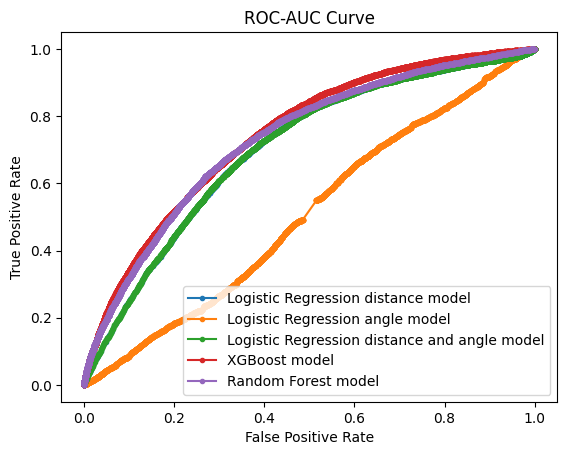

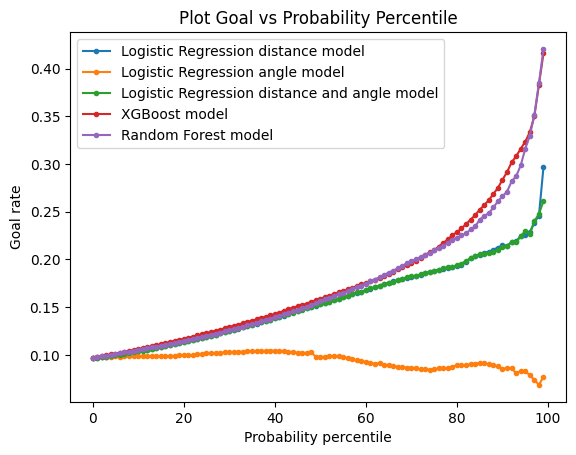

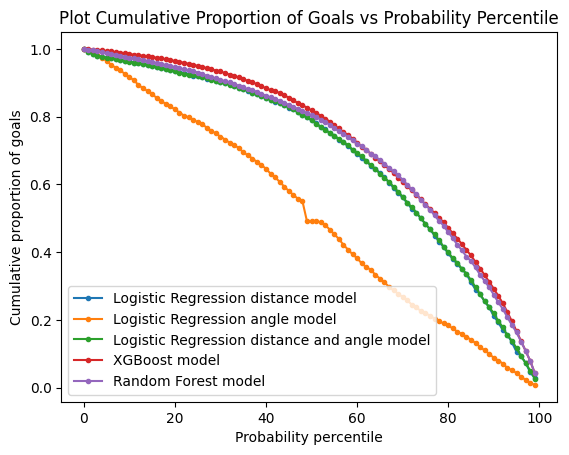

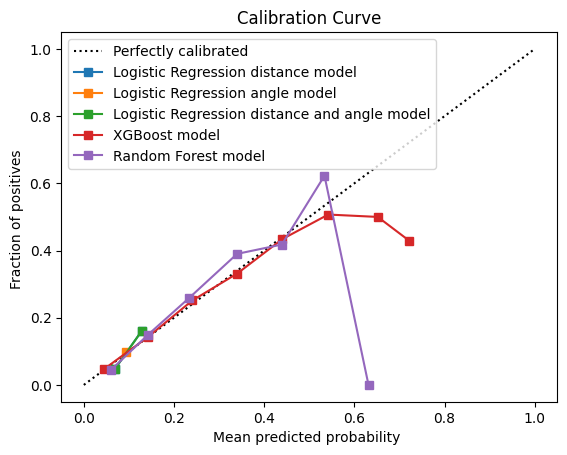

In [180]:
    # Regular curves
    plot_roc_curve(lr_1_regular_f1_fpr, lr_1_regular_f1_tpr, lr_2_regular_f1_fpr, lr_2_regular_f1_tpr, lr_3_regular_f1_fpr, lr_3_regular_f1_tpr, xgb_regular_f2_fpr, xgb_regular_f2_tpr,Random_forest_regular_f2_fpr,Random_forest_regular_f2_tpr)
    plot_goal_rate_vs_probability_percentile(y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs, Random_forest_regular_f2_probs)
    plot_cumulative_proportion_of_goals_vs_probability_percentile(y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs, Random_forest_regular_f2_probs)
    plot_calibration_curve(df_regular_f1,df_regular_f2,y_regular_f1,y_regular_f2,lr_1_regular_f1_probs, lr_2_regular_f1_probs, lr_3_regular_f1_probs, xgb_regular_f2_probs,Random_forest_regular_f2_probs)


In [181]:
    X_playoff_f1 = df_playoff_f1[['shot_distance']]
    y_playoff_f1 = df_playoff_f1['goal']

    # Predict on regular and playoff test set data from feature engineering 1
    lr_1_playoff_f1 = lr_1_model.predict(X_playoff_f1)

    # Predict accuracy on regular and playoff test set data from feature engineering 1
    # Playoff
    lr_1_playoff_f1_accuracy = accuracy_score(y_playoff_f1, lr_1_playoff_f1)
    print("Logistic Regression distance model accuracy on playoff test set data from feature engineering 1: ", lr_1_playoff_f1_accuracy)

    # ROC Curve
    # calculate scores
    lr_1_playoff_f1_probs = lr_1_model.predict_proba(X_playoff_f1)
    # keep probabilities for the positive outcome only
    lr_1_playoff_f1_probs = lr_1_playoff_f1_probs[:, 1]
    # calculate roc curves
    lr_1_playoff_f1_fpr, lr_1_playoff_f1_tpr, _ = roc_curve(y_playoff_f1, lr_1_playoff_f1_probs)
    # calculate AUC
    lr_1_playoff_f1_auc = roc_auc_score(y_playoff_f1, lr_1_playoff_f1_probs)


Logistic Regression distance model accuracy on playoff test set data from feature engineering 1:  0.9103477167993297


In [182]:
    X_playoff_f1 = df_playoff_f1[['shot_angle']]
    y_playoff_f1 = df_playoff_f1['goal']

    # Predict on regular and playoff test set data from feature engineering 1
    lr_2_playoff_f1 = lr_2_model.predict(X_playoff_f1)

    # Predict accuracy on regular and playoff test set data from feature engineering 1
    # Playoff
    lr_2_playoff_f1_accuracy = accuracy_score(y_playoff_f1, lr_2_playoff_f1)
    print("Logistic Regression angle model accuracy on playoff test set data from feature engineering 1: ", lr_2_playoff_f1_accuracy)

    # calculate scores
    lr_2_playoff_f1_probs = lr_2_model.predict_proba(X_playoff_f1)
    # keep probabilities for the positive outcome only
    lr_2_playoff_f1_probs = lr_2_playoff_f1_probs[:, 1]
    # calculate roc curves
    lr_2_playoff_f1_fpr, lr_2_playoff_f1_tpr, _ = roc_curve(y_playoff_f1, lr_2_playoff_f1_probs)
    # calculate AUC
    lr_2_playoff_f1_auc = roc_auc_score(y_playoff_f1, lr_2_playoff_f1_probs)

Logistic Regression angle model accuracy on playoff test set data from feature engineering 1:  0.9103477167993297


In [183]:
    # Divide data into X and y
    X_playoff_f1 = df_playoff_f1[['shot_distance', 'shot_angle']]
    y_playoff_f1 = df_playoff_f1['goal']

    # Predict on regular and playoff test set data from feature engineering 1
    lr_3_playoff_f1 = lr_3_model.predict(X_playoff_f1)

    # Predict accuracy on regular and playoff test set data from feature engineering 1
    # Playoff
    lr_3_playoff_f1_accuracy = accuracy_score(y_playoff_f1, lr_3_playoff_f1)
    print("Logistic Regression distance and angle model accuracy on playoff test set data from feature engineering 1: ", lr_3_playoff_f1_accuracy)

    # ROC curve for regular data
    # calculate scores
    lr_3_playoff_f1_probs = lr_3_model.predict_proba(X_playoff_f1)
    # keep probabilities for the positive outcome only
    lr_3_playoff_f1_probs = lr_3_playoff_f1_probs[:, 1]
    # calculate roc curves
    lr_3_playoff_f1_fpr, lr_3_playoff_f1_tpr, _ = roc_curve(y_playoff_f1, lr_3_playoff_f1_probs)
    # calculate AUC
    lr_3_playoff_f1_auc = roc_auc_score(y_playoff_f1, lr_3_playoff_f1_probs)

Logistic Regression distance and angle model accuracy on playoff test set data from feature engineering 1:  0.9103477167993297


In [184]:
    # Preprocess data
    df_playoff_f2 = preprocess_data(df_playoff_f2)

    # Divide data into X and y
    X_playoff_f2 = df_playoff_f2[['shot_angle','speed','shot_distance','distance_from_last_event','period_time','coordinates_y','time_from_last_event(s)']]
    y_playoff_f2 = df_playoff_f2['goal']

    # Predict on regular and playoff test set data from feature engineering 2
    xgb_playoff_f2 = xgb_model.predict(X_playoff_f2)

    # Predict accuracy on regular and playoff test set data from feature engineering 2
    # Playoff
    xgb_playoff_f2_accuracy = accuracy_score(y_playoff_f2, xgb_playoff_f2)
    print("XGBoost model accuracy on playoff test set data from feature engineering 2: ", xgb_playoff_f2_accuracy)

    # calculate scores
    xgb_playoff_f2_probs = xgb_model.predict_proba(X_playoff_f2)
    # keep probabilities for the positive outcome only
    xgb_playoff_f2_probs = xgb_playoff_f2_probs[:, 1]
    # calculate roc curves
    xgb_playoff_f2_fpr, xgb_playoff_f2_tpr, _ = roc_curve(y_playoff_f2, xgb_playoff_f2_probs)
    # calculate AUC
    xgb_playoff_f2_auc = roc_auc_score(y_playoff_f2, xgb_playoff_f2_probs)

C:\Users\pupne\AppData\Local\Temp\ipykernel_31204\1822981349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period_time'] = df['period_time'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))


XGBoost model accuracy on playoff test set data from feature engineering 2:  0.909509844993716


In [185]:
    df_playoff_f2 = test_set_data("D:/NHLPro/data/M2_added_features_all_test_playoff.csv")
    
    # Load Random Forest Model
    Random_forest_model = joblib.load("models/model2.joblib")

    # Preprocess data
    df_playoff_f2 = preprocess_data_random(df_playoff_f2)

    df_playoff_f2 = df_playoff_f2.drop(['Unnamed: 0'],axis=1)
    df_playoff_f2['last_event_type_Penalty'] = 0
    df_playoff_f2['last_event_type_Goal'] = 0

    # Divide data into X and y
    X_playoff_f2 = df_playoff_f2.drop(['goal'],axis=1)
    y_playoff_f2 = df_playoff_f2['goal']

    # Predict on regular and playoff test set data from feature engineering 2
    Random_forest_playoff_f2 = Random_forest_model.predict(X_playoff_f2)

    # Predict accuracy on regular and playoff test set data from feature engineering 2
    # Accuracy
    Random_forest_regular_f2_accuracy = accuracy_score(y_playoff_f2, Random_forest_playoff_f2)
    print("Random Forest accuracy on regular test set data from feature engineering 2: ", Random_forest_regular_f2_accuracy)
    
    # calculate scores
    Random_forest_playoff_f2_probs = Random_forest_model.predict_proba(X_playoff_f2)
    # keep probabilities for the positive outcome only
    Random_forest_playoff_f2_probs = Random_forest_playoff_f2_probs[:, 1]
    # calculate roc curves
    Random_forest_playoff_f2_fpr, Random_forest_playoff_f2_tpr, _ = roc_curve(y_playoff_f2, Random_forest_playoff_f2_probs)
    # calculate AUC
    Random_forest_playoff_f2_auc = roc_auc_score(y_playoff_f2, Random_forest_playoff_f2_probs)

    print('Random forest model: ROC AUC=%.3f' % (Random_forest_playoff_f2_auc))

XGBoost model accuracy on regular test set data from feature engineering 2:  0.9103477167993297
Random forest model: ROC AUC=0.660


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


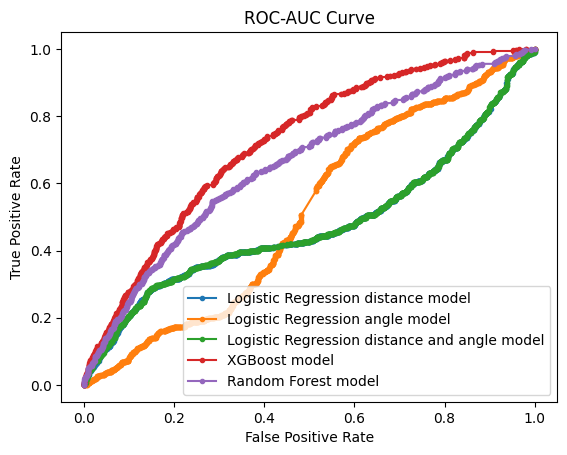

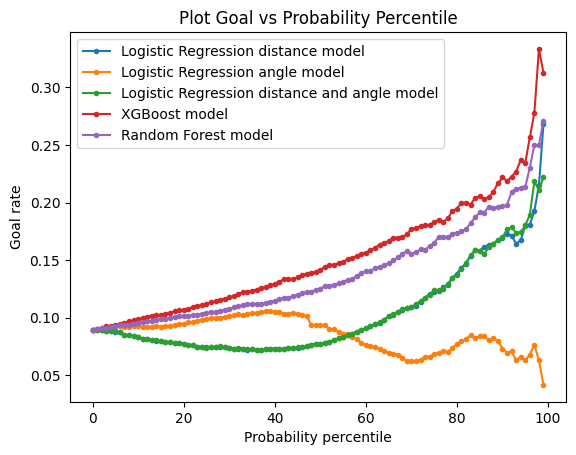

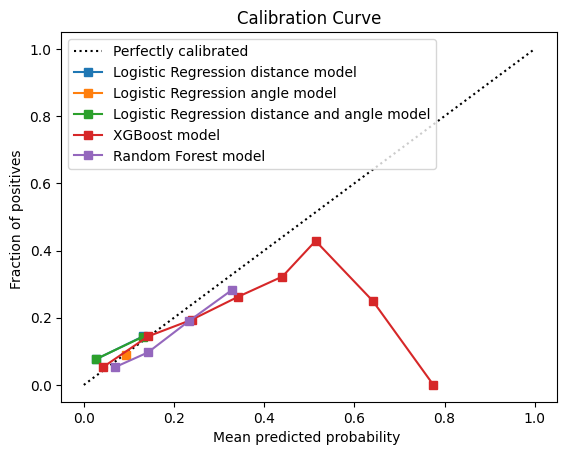

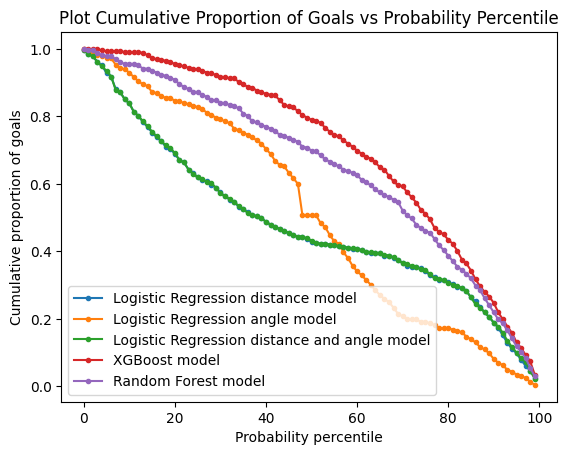

In [186]:
    plot_roc_curve(lr_1_playoff_f1_fpr, lr_1_playoff_f1_tpr, lr_2_playoff_f1_fpr, lr_2_playoff_f1_tpr, lr_3_playoff_f1_fpr, lr_3_playoff_f1_tpr, xgb_playoff_f2_fpr, xgb_playoff_f2_tpr, Random_forest_playoff_f2_fpr, Random_forest_playoff_f2_tpr)
    plot_goal_rate_vs_probability_percentile(y_playoff_f1,y_playoff_f2,lr_1_playoff_f1_probs, lr_2_playoff_f1_probs, lr_3_playoff_f1_probs, xgb_playoff_f2_probs, Random_forest_playoff_f2_probs)
    plot_calibration_curve(df_playoff_f1,df_playoff_f2,y_playoff_f1,y_playoff_f2,lr_1_playoff_f1_probs, lr_2_playoff_f1_probs, lr_3_playoff_f1_probs, xgb_playoff_f2_probs, Random_forest_playoff_f2_probs)
    plot_cumulative_proportion_of_goals_vs_probability_percentile(y_playoff_f1,y_playoff_f2,lr_1_playoff_f1_probs, lr_2_playoff_f1_probs, lr_3_playoff_f1_probs, xgb_playoff_f2_probs, Random_forest_playoff_f2_probs)
